# Imports

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math

# Enable inline plotting
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Dataset

In [2]:
''' Normalize input to the range of [0..1]
    Apart from assisting in the convergance of the training process, this 
    will also make our lives easier during the adversarial attack process
'''
def normalize(x_train,x_test):
    x_train -= x_train.min()
    x_train /= x_train.max()
    x_test -= x_test.min()
    x_test /= x_test.max()
    
    return x_train, x_test

In [3]:
# Load and prepare the datasets for training
num_classes = 10

img_rows, img_cols, img_colors = 28, 28, 1
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)

test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
train_images, test_images = normalize(train_images, test_images)

train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

## 1. Defensive Distilation

In [39]:
''' Build a simple MNIST classification CNN with Temperature
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense, Temperature
'''
def build_mnist_temperature_model(n_classes, temp=30):
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes, name='logits'))
    model.add(layers.Lambda(lambda x: x / temp))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [5]:
def train_distillation(labels=None, temp=30):
    # Train the model
    batch_size = 128
    maxepoches = 12
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20
    
    # no labels indicate teacher network, use train labels
    if labels is None:
        labels = train_labels

    sess = tf.Session()
    keras.backend.set_session(sess)

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    model = build_mnist_temperature_model(num_classes, temp)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_images, labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_images, test_labels),
                        callbacks=[reduce_lr])
    return model

## 2. CNN Model for MNIST Detection

In [6]:
''' Build a simple MNIST classification CNN
    The network takes ~3 minutes to train on a normal laptop and reaches roughly 97% of accuracy
    Model structure: Conv, Conv, Max pooling, Dropout, Dense, Dense
'''
def build_mnist_model(n_classes=None):
    activation = 'relu'
    # input image dimensions
    img_rows, img_cols, img_colors = 28, 28, 1
    if n_classes is None:
        n_classes = num_classes
    
    model = keras.Sequential()
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes, name='logits'))
    model.add(layers.Activation('softmax', name='y_pred'))
              
    return model

In [7]:
def train_cnn(train_x=None, train_y=None, test_x=None, test_y=None, n_classes=None):
    # Train the model
    batch_size = 128
    maxepoches = 12
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20
    
    if train_x is None:
        train_x = train_images
    
    if train_y is None:
        train_y = train_labels
        
    if test_x is None:
        test_x = test_images
    
    if test_y is None:
        test_y = test_labels
        
    if n_classes is None:
        n_classes = num_classes

    sess = tf.Session()
    keras.backend.set_session(sess)

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    model = build_mnist_model(n_classes=n_classes)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(train_x, train_y,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(test_x, test_y),
                        callbacks=[reduce_lr])
    return model


In [8]:
cnn = train_cnn()

W0617 19:00:26.171215 4460811712 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 228us/sample - loss: 0.9881 - categorical_accuracy: 0.6765 - val_loss: 0.3279 - val_categorical_accuracy: 0.9104
Epoch 2/12
60000/60000 [==============================] - 13s 223us/sample - loss: 0.4772 - categorical_accuracy: 0.8511 - val_loss: 0.2388 - val_categorical_accuracy: 0.9333
Epoch 3/12
60000/60000 [==============================] - 14s 226us/sample - loss: 0.3808 - categorical_accuracy: 0.8842 - val_loss: 0.1913 - val_categorical_accuracy: 0.9473
Epoch 4/12
60000/60000 [==============================] - 13s 225us/sample - loss: 0.3192 - categorical_accuracy: 0.9029 - val_loss: 0.1606 - val_categorical_accuracy: 0.9547
Epoch 5/12
60000/60000 [==============================] - 14s 225us/sample - loss: 0.2792 - categorical_accuracy: 0.9157 - val_loss: 0.1388 - val_categorical_accuracy: 0.9598
Epoch 6/12
60000/60000 [==============================] - 13s 224us/sample 

## Attack Utilities

In [9]:
timages = tf.constant(test_images)
tlabels = tf.constant(test_labels)

# Choose random target classes per each instance in the test set
target = (np.argmax(test_labels, axis=1) + np.random.randint(1, num_classes, size=(test_labels.shape[0]))) % num_classes
target = keras.utils.to_categorical(target, num_classes)
ttarget = tf.constant(target)

In [10]:
''' A simple utility funcion for evaluating the success of an attack
'''
def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))
    
    if targeted:
        score = model.evaluate(adv_images, target_labels, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))
    
    index = 3
    img = adv_images[index].reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()
    
    ret_score = score[1] if targeted else 1 - score[1]
    return ret_score, dist

## 3. FGSM, TGSM and PGD Attacks on CNN Model

In [11]:
''' Fast Gradient Sign Method implementation - perturb all input features by an epsilon sized step in 
    the direction of loss gradient
'''
def FGSM(model, images, labels, epsilon=0.3):  
    adv_loss = keras.losses.categorical_crossentropy(labels, model(images))
    grads_wrt_input, = keras.backend.gradients(adv_loss, images)
    sign_grads = keras.backend.sign(grads_wrt_input)
    
    delta = epsilon * sign_grads
    images_adv  = images + delta
    
    return images_adv

In [12]:
''' Targeted Gradient Sign Method implementation - A targeted variant of the FGSM attack
    here we minimize the loss with respect to the target class, as opposed to maximizing the loss with respect
    to the source class
'''
def TGSM(model, images, target, epsilon=0.3):
    adv_loss = keras.losses.categorical_crossentropy(target, model(images))
    grads_wrt_input, = keras.backend.gradients(adv_loss, images)
    sign_grads = keras.backend.sign(grads_wrt_input)
    
    delta = epsilon * sign_grads
    images_adv  = images - delta    
    
    return images_adv

In [13]:
def PGD(model, images, labels, epsilon=4.0, iter_eps=0.05, iterations=30, min_x=0.0, max_x=1.0, targeted=False):
    # support batch  pertrubation
    adv_out = images
    
    # loop stop condition
    cond = lambda i, _: tf.less(i, iterations)
    
    # loop body
    def body(i, adv_out):
        # support targeted and untargeted
        if targeted:
            adv_out = TGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants
        else:
            adv_out = FGSM(model, adv_out, labels, epsilon=iter_eps)  # different eps constants

        perturbation = adv_out - images
        # clip to allowed epsilon radius
        norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
        norm = tf.sqrt(tf.maximum(1e-11, norm))  # assure numerical stability
        factor = tf.minimum(1., tf.math.divide(epsilon, norm))  # perform projection when exceeding radius
        adv_out = images + perturbation * factor
        adv_out = tf.clip_by_value(adv_out, min_x, max_x)  # clip outputs to allowed values
        
        return i+1, adv_out
    
    _, adv_out = tf.while_loop(cond, body, (tf.zeros([]), adv_out), back_prop=True,
                             maximum_iterations=iterations)
    
    return adv_out

In [14]:
def attack(model):
    scores = {}
    sess = keras.backend.get_session()
    
    # FGSM attack
    fgsm_images_adv = FGSM(model, timages, tlabels)
    fgsm_out = sess.run(fgsm_images_adv)
    scores['fgsm'] = TestAttack(model, fgsm_out, test_images, test_labels, target, targeted=False)
    
    # TGSM attack
    tgsm_images_adv = TGSM(model, timages, ttarget)
    tgsm_out = sess.run(tgsm_images_adv)
    scores['tgsm'] = TestAttack(model, tgsm_out, test_images, test_labels, target, targeted=True)
    
    # PGD attack
    pgd_images_adv = PGD(model, timages, tlabels)
    pgd_out = sess.run(pgd_images_adv)
    scores['pgd'] = TestAttack(model, pgd_out, test_images, test_labels, target, targeted=False)
    
    # PGD targeted attack
    pgd_t_images_adv = PGD(model, timages, ttarget, targeted=True)
    pgd_t_out = sess.run(pgd_t_images_adv)
    scores['pgd_targeted'] = TestAttack(model, pgd_t_out, test_images, test_labels, target, targeted=True)
    
    return scores

Test loss: 4.49
Successfully moved out of source class: 0.95
Mean perturbation distance: 0.29


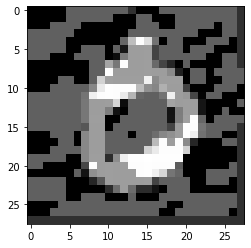

Test loss: 3.48
Successfully moved out of source class: 0.88
Test loss: 1.40
Successfully perturbed to target class: 0.53
Mean perturbation distance: 0.29


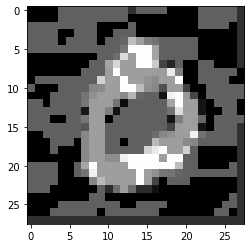

Test loss: 5.20
Successfully moved out of source class: 0.96
Mean perturbation distance: 0.14


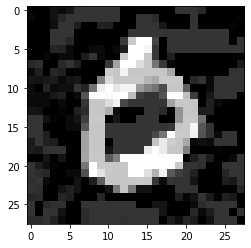

Test loss: 2.67
Successfully moved out of source class: 0.72
Test loss: 0.98
Successfully perturbed to target class: 0.69
Mean perturbation distance: 0.14


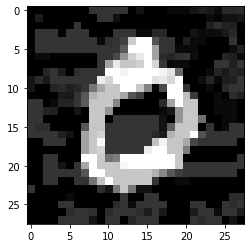

In [15]:
cnn_results = attack(cnn)

## 4. Train Defensive Distilled Model

In [16]:
teacher = train_distillation()

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 231us/sample - loss: 1.6809 - categorical_accuracy: 0.4664 - val_loss: 0.4752 - val_categorical_accuracy: 0.8748
Epoch 2/12
60000/60000 [==============================] - 14s 225us/sample - loss: 0.5918 - categorical_accuracy: 0.8147 - val_loss: 0.3334 - val_categorical_accuracy: 0.9055
Epoch 3/12
60000/60000 [==============================] - 14s 225us/sample - loss: 0.4938 - categorical_accuracy: 0.8482 - val_loss: 0.2901 - val_categorical_accuracy: 0.9184
Epoch 4/12
60000/60000 [==============================] - 14s 225us/sample - loss: 0.4507 - categorical_accuracy: 0.8604 - val_loss: 0.2660 - val_categorical_accuracy: 0.9241
Epoch 5/12
60000/60000 [==============================] - 14s 226us/sample - loss: 0.4202 - categorical_accuracy: 0.8701 - val_loss: 0.2456 - val_categorical_accuracy: 0.9277
Epoch 6/12
60000/60000 [==============================] - 14s 225us/sample 

In [17]:
teacher_labels = teacher.predict(train_images)
student = train_distillation(labels=teacher_labels)

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 15s 250us/sample - loss: 2.1967 - categorical_accuracy: 0.2670 - val_loss: 1.1275 - val_categorical_accuracy: 0.7664
Epoch 2/12
60000/60000 [==============================] - 14s 237us/sample - loss: 0.7209 - categorical_accuracy: 0.7789 - val_loss: 0.3708 - val_categorical_accuracy: 0.8954
Epoch 3/12
60000/60000 [==============================] - 14s 231us/sample - loss: 0.5197 - categorical_accuracy: 0.8542 - val_loss: 0.3213 - val_categorical_accuracy: 0.9077
Epoch 4/12
60000/60000 [==============================] - 14s 233us/sample - loss: 0.4709 - categorical_accuracy: 0.8741 - val_loss: 0.2982 - val_categorical_accuracy: 0.9159
Epoch 5/12
60000/60000 [==============================] - 14s 233us/sample - loss: 0.4451 - categorical_accuracy: 0.8841 - val_loss: 0.2776 - val_categorical_accuracy: 0.9200
Epoch 6/12
60000/60000 [==============================] - 15s 248us/sample 

In [18]:
student_inference = build_mnist_model()
student_inference.set_weights(student.get_weights())
student_inference.compile(loss='categorical_crossentropy',
                          optimizer=keras.optimizers.Adadelta(),
                          metrics=[keras.metrics.CategoricalAccuracy()])

## 5. FGSM, TGSM and PGD Attacks on Distilled Model

Test loss: 58.32
Successfully moved out of source class: 0.28
Mean perturbation distance: 0.09


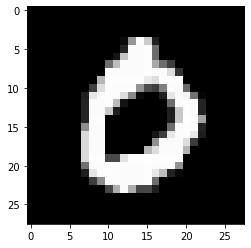

Test loss: 108.41
Successfully moved out of source class: 0.90
Test loss: 27.91
Successfully perturbed to target class: 0.54
Mean perturbation distance: 0.29


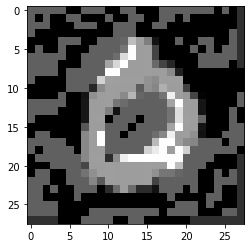

Test loss: 59.35
Successfully moved out of source class: 0.29
Mean perturbation distance: 0.04


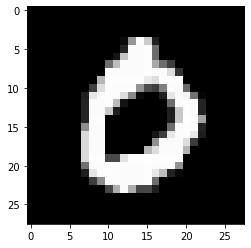

Test loss: 26.15
Successfully moved out of source class: 0.68
Test loss: 28.54
Successfully perturbed to target class: 0.60
Mean perturbation distance: 0.14


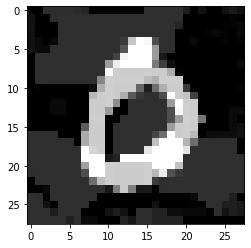

In [19]:
distilled_results = attack(student_inference)

## 6. Binary Distilled Classifier

In [20]:
binary_classes = list(np.random.choice(num_classes, 2, replace=False))

In [21]:
def to_one_hot(num):
    x = np.zeros(num_classes)
    x[num] = 1
    return x

In [22]:
negative_class = to_one_hot(binary_classes[0])
positive_class = to_one_hot(binary_classes[1])

negative_train_indices = (train_labels == negative_class).all(axis=1).nonzero()
positive_train_indices = (train_labels == positive_class).all(axis=1).nonzero()
negative_test_indices = (test_labels == negative_class).all(axis=1).nonzero()
positive_test_indices = (test_labels == positive_class).all(axis=1).nonzero()

negative_train_images = train_images[negative_train_indices]
positive_train_images = train_images[positive_train_indices]
negative_test_images = test_images[negative_test_indices]
positive_test_images = test_images[positive_test_indices]

In [23]:
num_train_negatives = len(negative_train_images)
num_train_positives = len(positive_train_images)
num_test_negatives = len(negative_test_images)
num_test_positives = len(positive_test_images)

binary_train_labels = np.zeros((num_train_negatives + num_train_positives, 2))
binary_train_labels[:num_train_negatives] = np.array([1., 0.])
binary_train_labels[num_train_negatives:] = np.array([0., 1.])
binary_test_labels = np.zeros((num_test_negatives + num_test_positives, 2))
binary_test_labels[:num_test_negatives] = np.array([1., 0.])
binary_test_labels[num_test_negatives:] = np.array([0., 1.])

binary_train_images = np.concatenate((negative_train_images, positive_train_images))
binary_test_images = np.concatenate((negative_test_images, positive_test_images))

In [24]:
# shuffle training samples
p = np.random.permutation(num_train_negatives + num_train_positives)
binary_train_images = binary_train_images[p]
binary_train_labels = binary_train_labels[p]

# shuffle test samples
q = np.random.permutation(num_test_negatives + num_test_positives)
binary_test_images = binary_test_images[q]
binary_test_labels = binary_test_labels[q]

In [25]:
def train_binary_distillation(labels=None, temp=30):
    # Train the model
    batch_size = 128
    maxepoches = 12
    learning_rate = 0.1
    lr_decay = 1e-6
    lr_drop = 20
    n_classes = 2
    
    # no labels indicate teacher network, use train labels
    if labels is None:
        labels = binary_train_labels

    sess = tf.Session()
    keras.backend.set_session(sess)

    def lr_scheduler(epoch):
        return learning_rate * (0.5 ** (epoch // lr_drop))
    reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

    model = build_mnist_temperature_model(n_classes, temp)

    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=[keras.metrics.CategoricalAccuracy()])

    history = model.fit(binary_train_images, binary_train_labels,
                        batch_size=batch_size,
                        epochs=maxepoches,
                        verbose=1,
                        validation_data=(binary_test_images, binary_test_labels),
                        callbacks=[reduce_lr])
    return model

In [41]:
binary_teacher = train_binary_distillation()

Train on 12054 samples, validate on 1990 samples
Epoch 1/12
12054/12054 [==============================] - 3s 288us/sample - loss: 0.6925 - categorical_accuracy: 0.5828 - val_loss: 0.6913 - val_categorical_accuracy: 0.8447
Epoch 2/12
12054/12054 [==============================] - 3s 274us/sample - loss: 0.6893 - categorical_accuracy: 0.7725 - val_loss: 0.6847 - val_categorical_accuracy: 0.9693
Epoch 3/12
12054/12054 [==============================] - 3s 276us/sample - loss: 0.6656 - categorical_accuracy: 0.8981 - val_loss: 0.5983 - val_categorical_accuracy: 0.9779
Epoch 4/12
12054/12054 [==============================] - 3s 269us/sample - loss: 0.3244 - categorical_accuracy: 0.9491 - val_loss: 0.0767 - val_categorical_accuracy: 0.9879
Epoch 5/12
12054/12054 [==============================] - 3s 283us/sample - loss: 0.0924 - categorical_accuracy: 0.9710 - val_loss: 0.0330 - val_categorical_accuracy: 0.9920
Epoch 6/12
12054/12054 [==============================] - 3s 288us/sample - loss:

In [42]:
binary_teacher_labels = binary_teacher.predict(binary_test_images)
binary_student = train_binary_distillation(labels=binary_teacher_labels)

Train on 12054 samples, validate on 1990 samples
Epoch 1/12
12054/12054 [==============================] - 4s 297us/sample - loss: 0.6874 - categorical_accuracy: 0.7112 - val_loss: 0.6739 - val_categorical_accuracy: 0.9653
Epoch 2/12
12054/12054 [==============================] - 3s 285us/sample - loss: 0.5759 - categorical_accuracy: 0.9212 - val_loss: 0.2723 - val_categorical_accuracy: 0.9814
Epoch 3/12
12054/12054 [==============================] - 3s 286us/sample - loss: 0.1466 - categorical_accuracy: 0.9652 - val_loss: 0.0464 - val_categorical_accuracy: 0.9899
Epoch 4/12
12054/12054 [==============================] - 3s 283us/sample - loss: 0.0713 - categorical_accuracy: 0.9771 - val_loss: 0.0276 - val_categorical_accuracy: 0.9930
Epoch 5/12
12054/12054 [==============================] - 3s 288us/sample - loss: 0.0580 - categorical_accuracy: 0.9809 - val_loss: 0.0209 - val_categorical_accuracy: 0.9935
Epoch 6/12
12054/12054 [==============================] - 3s 279us/sample - loss:

In [44]:
binary_student_inference = build_mnist_model(n_classes=2)
binary_student_inference.set_weights(binary_student.get_weights())
binary_student_inference.compile(loss='categorical_crossentropy',
                          optimizer=keras.optimizers.Adadelta(),
                          metrics=[keras.metrics.CategoricalAccuracy()])

In [29]:
timages_binary = tf.constant(binary_test_images)
tlabels_binary = tf.constant(binary_test_labels)

In [67]:
opposite_binary_labels = np.ones(binary_test_labels.shape) - binary_test_labels
topposite_binary_labels = tf.constant(opposite_binary_labels)

In [72]:
def binary_attack(model):
    scores = {}
    sess = keras.backend.get_session()
    
    # FGSM attack
    fgsm_images_adv = FGSM(model, timages_binary, tlabels_binary)
    fgsm_out = sess.run(fgsm_images_adv)
    scores['fgsm'] = TestAttack(model, fgsm_out, binary_test_images, binary_test_labels, _, targeted=False)
    
    # TGSM attack
    tgsm_images_adv = TGSM(model, timages_binary, topposite_binary_labels)
    tgsm_out = sess.run(tgsm_images_adv)
    scores['tgsm'] = TestAttack(model, tgsm_out, binary_test_images, binary_test_labels, opposite_binary_labels, targeted=True)
    
    # PGD attack
    pgd_images_adv = PGD(model, timages_binary, tlabels_binary)
    pgd_out = sess.run(pgd_images_adv)
    scores['pgd'] = TestAttack(model, pgd_out, binary_test_images, binary_test_labels, _, targeted=False)
    
    # PGD targeted attack
    pgd_t_images_adv = PGD(model, timages_binary, topposite_binary_labels, targeted=True)
    pgd_t_out = sess.run(pgd_t_images_adv)
    scores['pgd_targeted'] = TestAttack(model, pgd_t_out, binary_test_images, binary_test_labels, opposite_binary_labels, targeted=True)
    
    return scores

Test loss: 7.05
Successfully moved out of source class: 0.03
Mean perturbation distance: 0.01


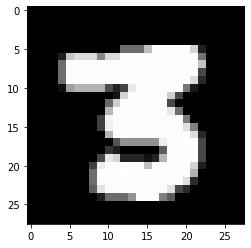

Test loss: 114.82
Successfully moved out of source class: 0.88
Test loss: 4.99
Successfully perturbed to target class: 0.88
Mean perturbation distance: 0.29


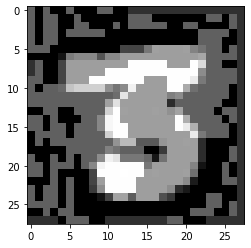

Test loss: 5.21
Successfully moved out of source class: 0.03
Mean perturbation distance: 0.00


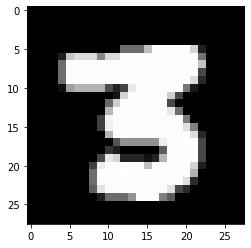

Test loss: 31.22
Successfully moved out of source class: 0.48
Test loss: 41.02
Successfully perturbed to target class: 0.48
Mean perturbation distance: 0.14


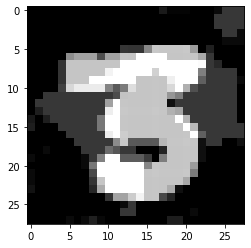

In [73]:
binary_distilled_results = binary_attack(binary_student_inference)

## 7. Visualize Distillation

In [32]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

In [33]:
regular_classifier = train_cnn(train_x=binary_train_images,
                              train_y=binary_train_labels,
                              test_x=binary_test_images,
                              test_y=binary_test_labels,
                              n_classes=2)

Train on 12054 samples, validate on 1990 samples
Epoch 1/12
12054/12054 [==============================] - 4s 304us/sample - loss: 0.3614 - categorical_accuracy: 0.8667 - val_loss: 0.0592 - val_categorical_accuracy: 0.9899
Epoch 2/12
12054/12054 [==============================] - 3s 264us/sample - loss: 0.0771 - categorical_accuracy: 0.9761 - val_loss: 0.0237 - val_categorical_accuracy: 0.9935
Epoch 3/12
12054/12054 [==============================] - 3s 264us/sample - loss: 0.0548 - categorical_accuracy: 0.9811 - val_loss: 0.0183 - val_categorical_accuracy: 0.9945
Epoch 4/12
12054/12054 [==============================] - 3s 267us/sample - loss: 0.0494 - categorical_accuracy: 0.9828 - val_loss: 0.0155 - val_categorical_accuracy: 0.9955
Epoch 5/12
12054/12054 [==============================] - 3s 266us/sample - loss: 0.0430 - categorical_accuracy: 0.9860 - val_loss: 0.0139 - val_categorical_accuracy: 0.9965
Epoch 6/12
12054/12054 [==============================] - 3s 266us/sample - loss:

In [34]:
positive_binary_test_indices = (binary_test_labels == np.array([0., 1.])).all(axis=1).nonzero()
binary_positive_test_images = binary_test_images[positive_binary_test_indices]
regular_logits_model = keras.Model(inputs=regular_classifier.input,
                                   outputs=regular_classifier.get_layer("logits").output)
regular_logits = regular_logits_model.predict(binary_positive_test_images)
softmax_values = regular_classifier.predict(binary_positive_test_images)

In [51]:
def plot(x, y):
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    ax.scatter(x, y, s=2)

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    plt.show()

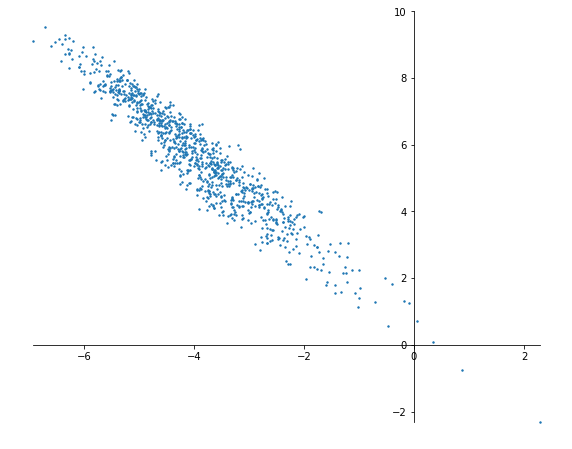

In [37]:
x, y = regular_logits[:,0], regular_logits[:,1]
plot(x, y)

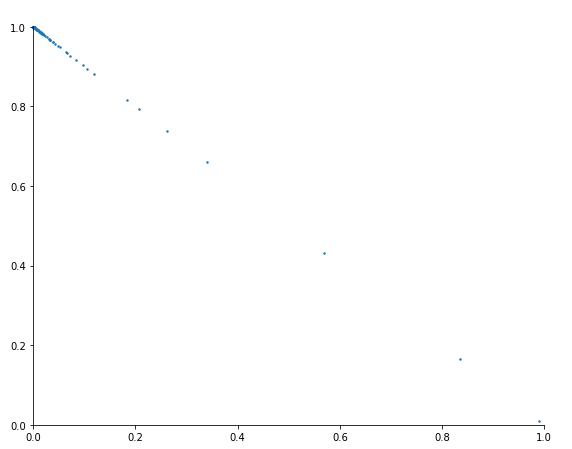

In [38]:
x, y = softmax_values[:,0], softmax_values[:,1]
plot(x, y)

In [48]:
distilled_logits_model = keras.Model(inputs=binary_student_inference.input,
                                     outputs=binary_student_inference.get_layer("logits").output)
regular_logits = distilled_logits_model.predict(binary_positive_test_images)
softmax_values = binary_student_inference.predict(binary_positive_test_images)

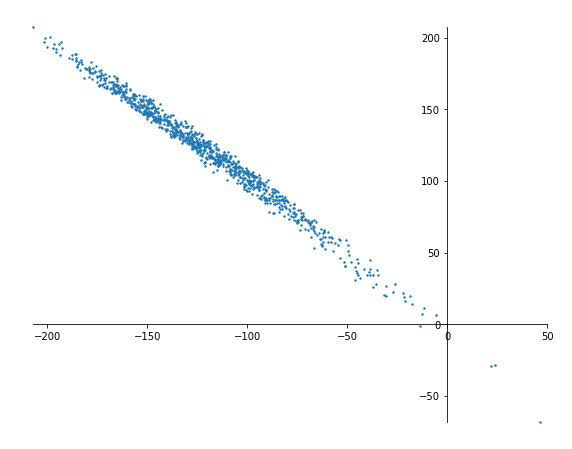

In [49]:
x, y = regular_logits[:,0], regular_logits[:,1]
plot(x, y)

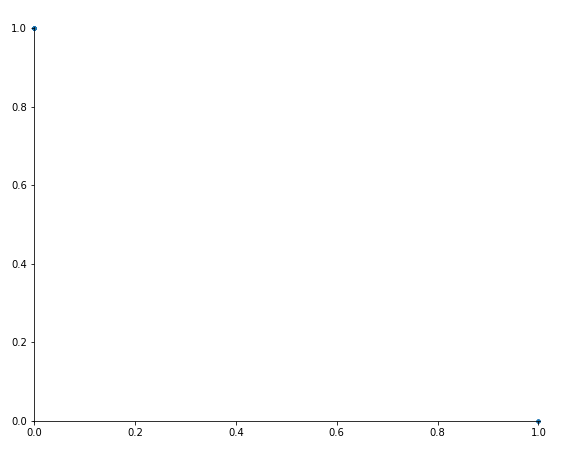

In [52]:
x, y = softmax_values[:,0], softmax_values[:,1]
plot(x, y)